### Loan payments - Machine Learning
###### [Mission] predicting loan status<br>[Data]<br>- data: various features for loan customers(principal, terms, age...)

### Prepare data

In [113]:
# base
import os
import pandas as pd
import numpy as np
import datetime

# visualization
import seaborn as sns
sns.set_style("dark")
import matplotlib.pyplot as plt
%matplotlib inline

# warnings
import warnings
warnings.filterwarnings("ignore")

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [78]:
# acquire data
def my_read_file(filename):
    df = pd.read_csv(filename)
    print("{}: Reading {}.".format(now(), filename))
    print("{}: The data contains {} observations with {} columns".format(now(), df.shape[0], df.shape[1]))
    return df

def now():
    tmp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return tmp

# find the missing data on the columns and # of missing
def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100],
            axis = 1, keys = ['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not panda DataFrame".format(now()))
   
    except (UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))

In [79]:
data = my_read_file('C:/Users/1004/git/kaggle/Loan/Loan payments data.csv')
print("\n\n")
print(checking_na(data))

2022-08-30 18:36:09: Reading C:/Users/1004/git/kaggle/Loan/Loan payments data.csv.
2022-08-30 18:36:09: The data contains 500 observations with 11 columns



               df_bool  df_amt  missing_ratio_percent
paid_off_time     True     100                   20.0
past_due_days     True     300                   60.0


In [80]:
data.head()

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


### Analyze by visualizing data

['PAIDOFF' 'COLLECTION' 'COLLECTION_PAIDOFF']


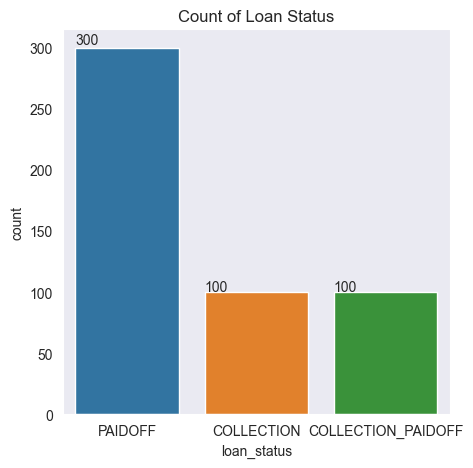

In [81]:
print(data.loan_status.unique())

fig = plt.figure(figsize = (5, 5))
ax = sns.countplot(data.loan_status)
ax.set_title("Count of Loan Status")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), 'd')), (p.get_x(), p.get_height()*1.01))
plt.show()

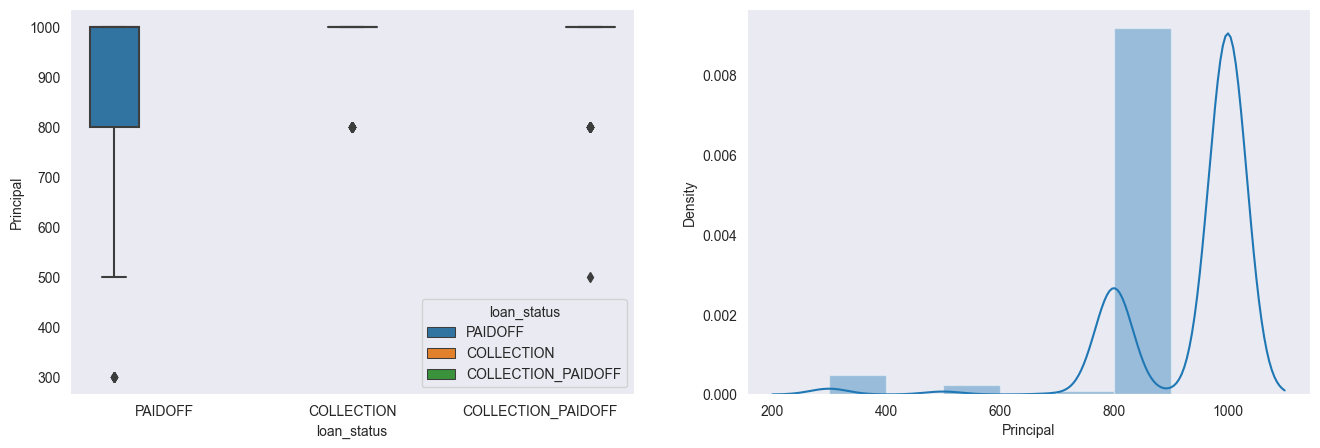

In [82]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
sns.boxplot(x = "loan_status", y = "Principal", data = data, hue = "loan_status", ax = axs[0])
sns.distplot(data.Principal, bins = range(300, 1000, 100), ax = axs[1], kde = True)
plt.show();

In [83]:
print(data[['loan_status', 'Principal', 'Loan_ID']].groupby(['loan_status', 'Principal']).agg(['count']))

                             Loan_ID
                               count
loan_status        Principal        
COLLECTION         800            23
                   1000           77
COLLECTION_PAIDOFF 500             1
                   800            19
                   1000           80
PAIDOFF            300             6
                   500             2
                   700             1
                   800            69
                   900             2
                   1000          220


In [84]:
data

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female
...,...,...,...,...,...,...,...,...,...,...,...
495,xqd20160496,COLLECTION_PAIDOFF,1000,30,9/12/2016,10/11/2016,10/14/2016 19:08,3.0,28,High School or Below,male
496,xqd20160497,COLLECTION_PAIDOFF,1000,15,9/12/2016,9/26/2016,10/10/2016 20:02,14.0,26,High School or Below,male
497,xqd20160498,COLLECTION_PAIDOFF,800,15,9/12/2016,9/26/2016,9/29/2016 11:49,3.0,30,college,male
498,xqd20160499,COLLECTION_PAIDOFF,1000,30,9/12/2016,11/10/2016,11/11/2016 22:40,1.0,38,college,female


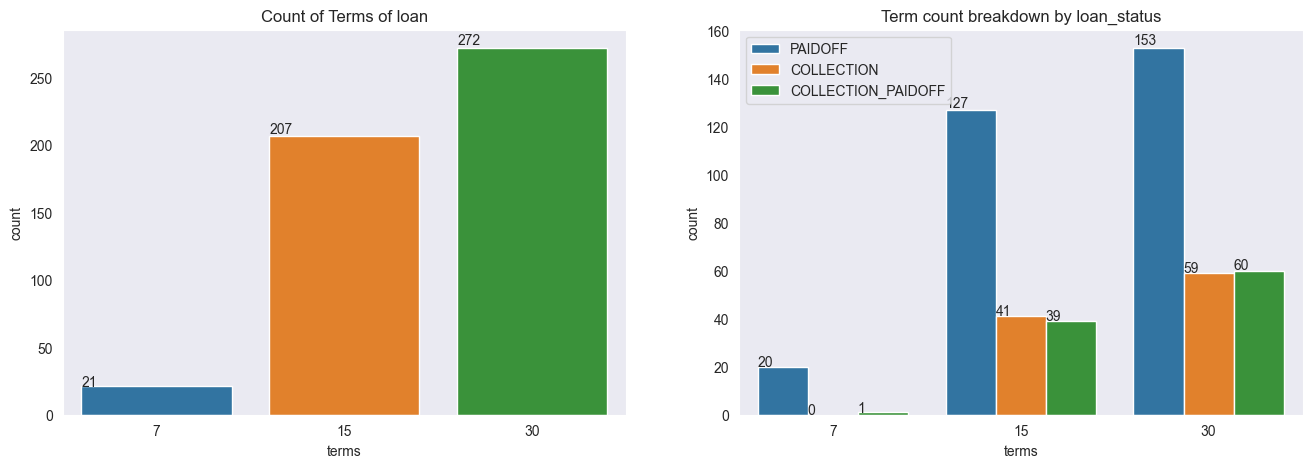

In [85]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
sns.countplot(data.terms, ax = axs[0])
axs[0].set_title("Count of Terms of loan")
for p in axs[0].patches:
    axs[0].annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

sns.countplot(x = 'terms', hue = 'loan_status', data = data, ax = axs[1])
axs[1].set_title("Term count breakdown by loan_status")
for t in axs[1].patches:
    if (np.isnan(float(t.get_height()))):
        axs[1].annotate(0, (t.get_x(), 0))
    else:
        axs[1].annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

axs[1].legend(loc = 'upper left')
plt.show();


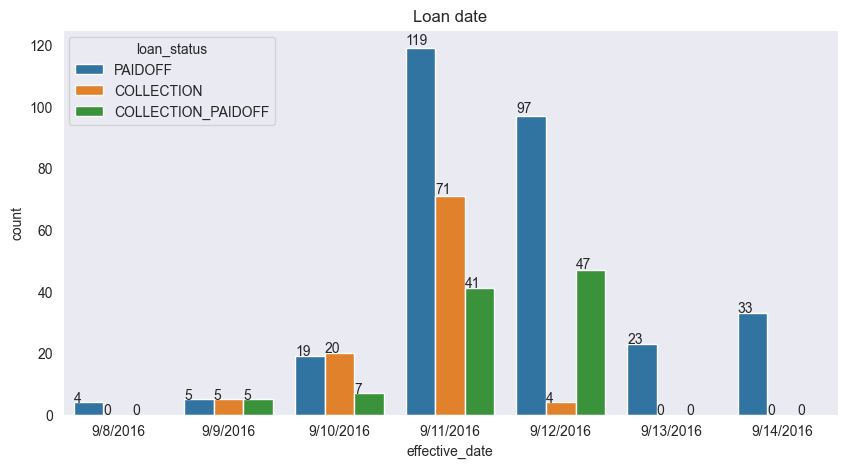

In [86]:
fig = plt.figure(figsize = (10, 5))
ax = sns.countplot(x = 'effective_date', hue = 'loan_status', data = data)
ax.set_title('Loan date')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height() * 1.01))
plt.show()

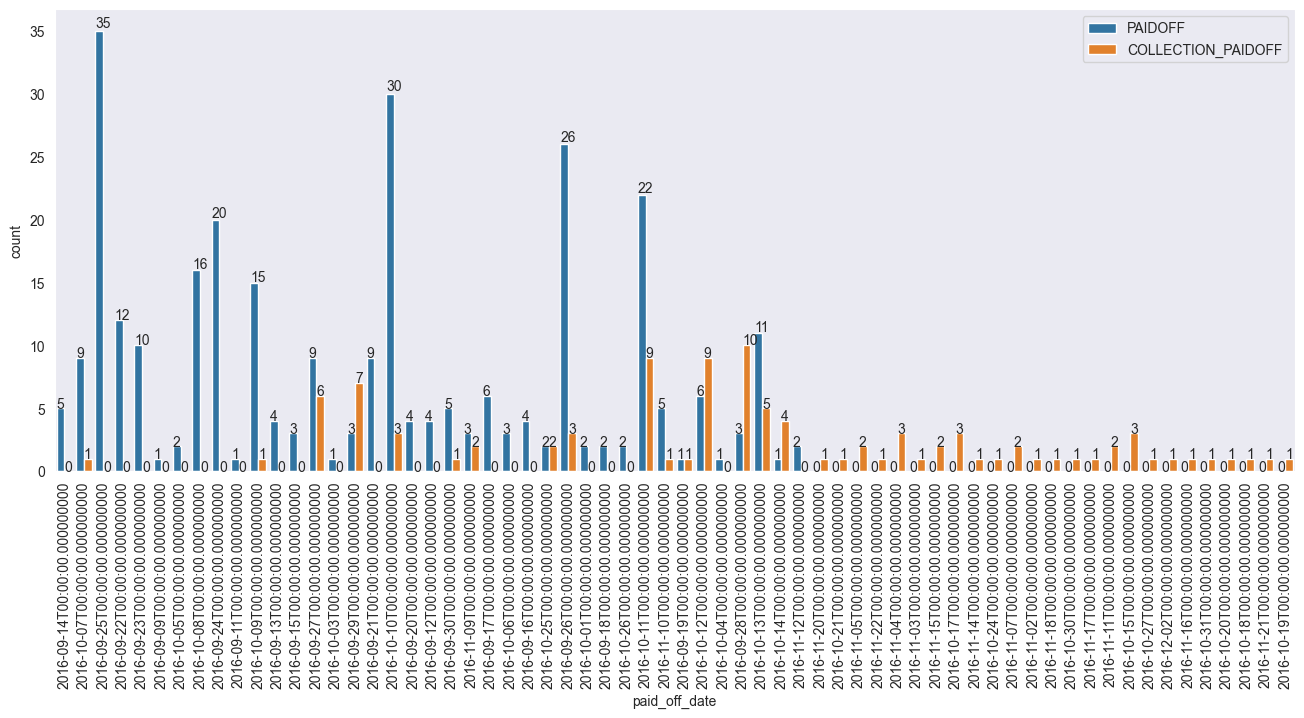

In [87]:
data['paid_off_date'] = pd.DatetimeIndex(data.paid_off_time).normalize()
fig = plt.figure(figsize = (16, 6))
ax = sns.countplot(x = 'paid_off_date', data = data.loc[data.loan_status.isin(['COLLECTION_PAIDOFF', 'PAIDOFF'])], hue = 'loan_status')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))
    
ax.legend(loc = 'upper right')
plt.show()

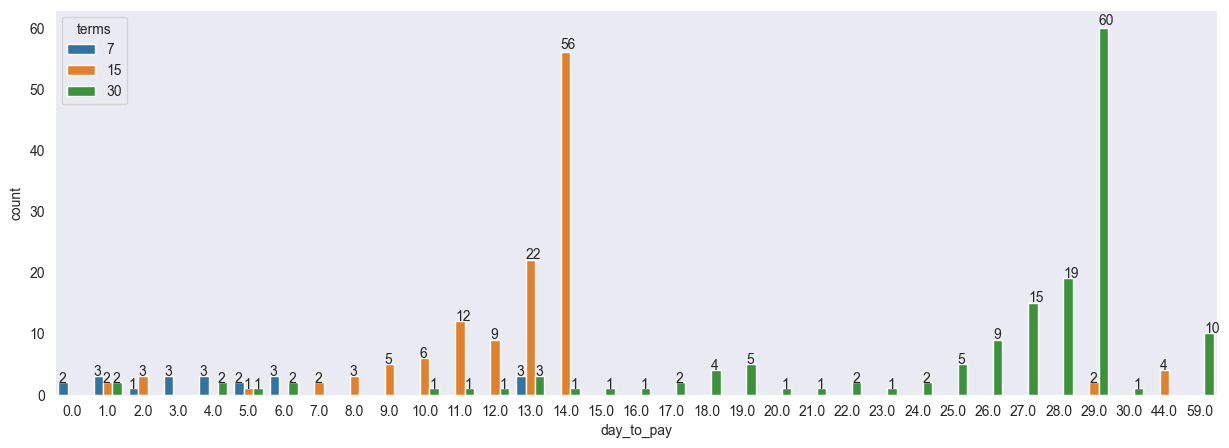

In [88]:
# compute the day to pay-off the loan
data['day_to_pay'] = (pd.DatetimeIndex(data.paid_off_time).normalize() - pd.DatetimeIndex(data.effective_date).normalize()) / np.timedelta64(1, 'D')

fig = plt.figure(figsize = (15, 5))
ax = sns.countplot(x = 'day_to_pay', hue = 'terms', data = data.loc[data.loan_status == 'PAIDOFF'])
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate('', (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

plt.show();
    

In [89]:
tmp = data.loc[(data.day_to_pay > 30) & (data.loan_status == 'PAIDOFF')]
print("{}: Incorrect status: {} observations".format(now(), tmp.shape[0]))
print(tmp[['loan_status', 'terms', 'effective_date', 'due_date', 'paid_off_time']])

2022-08-30 18:36:12: Incorrect status: 14 observations
    loan_status  terms effective_date    due_date     paid_off_time
85      PAIDOFF     30      9/11/2016   11/9/2016    11/9/2016 9:00
111     PAIDOFF     30      9/11/2016   11/9/2016    11/9/2016 9:00
122     PAIDOFF     15      9/11/2016  10/25/2016   10/25/2016 9:00
137     PAIDOFF     15      9/11/2016  10/25/2016   10/25/2016 9:00
146     PAIDOFF     30      9/11/2016   11/9/2016   11/9/2016 23:00
150     PAIDOFF     15      9/12/2016  10/26/2016   10/26/2016 9:00
165     PAIDOFF     30      9/12/2016  11/10/2016  11/10/2016 16:00
196     PAIDOFF     30      9/12/2016  11/10/2016  11/10/2016 13:00
206     PAIDOFF     30      9/12/2016  11/10/2016  11/10/2016 13:00
215     PAIDOFF     30      9/12/2016  11/10/2016  11/10/2016 16:00
222     PAIDOFF     30      9/12/2016  11/10/2016  11/10/2016 13:00
230     PAIDOFF     15      9/12/2016  10/26/2016   10/26/2016 9:00
272     PAIDOFF     30      9/14/2016  11/12/2016   11/12/201

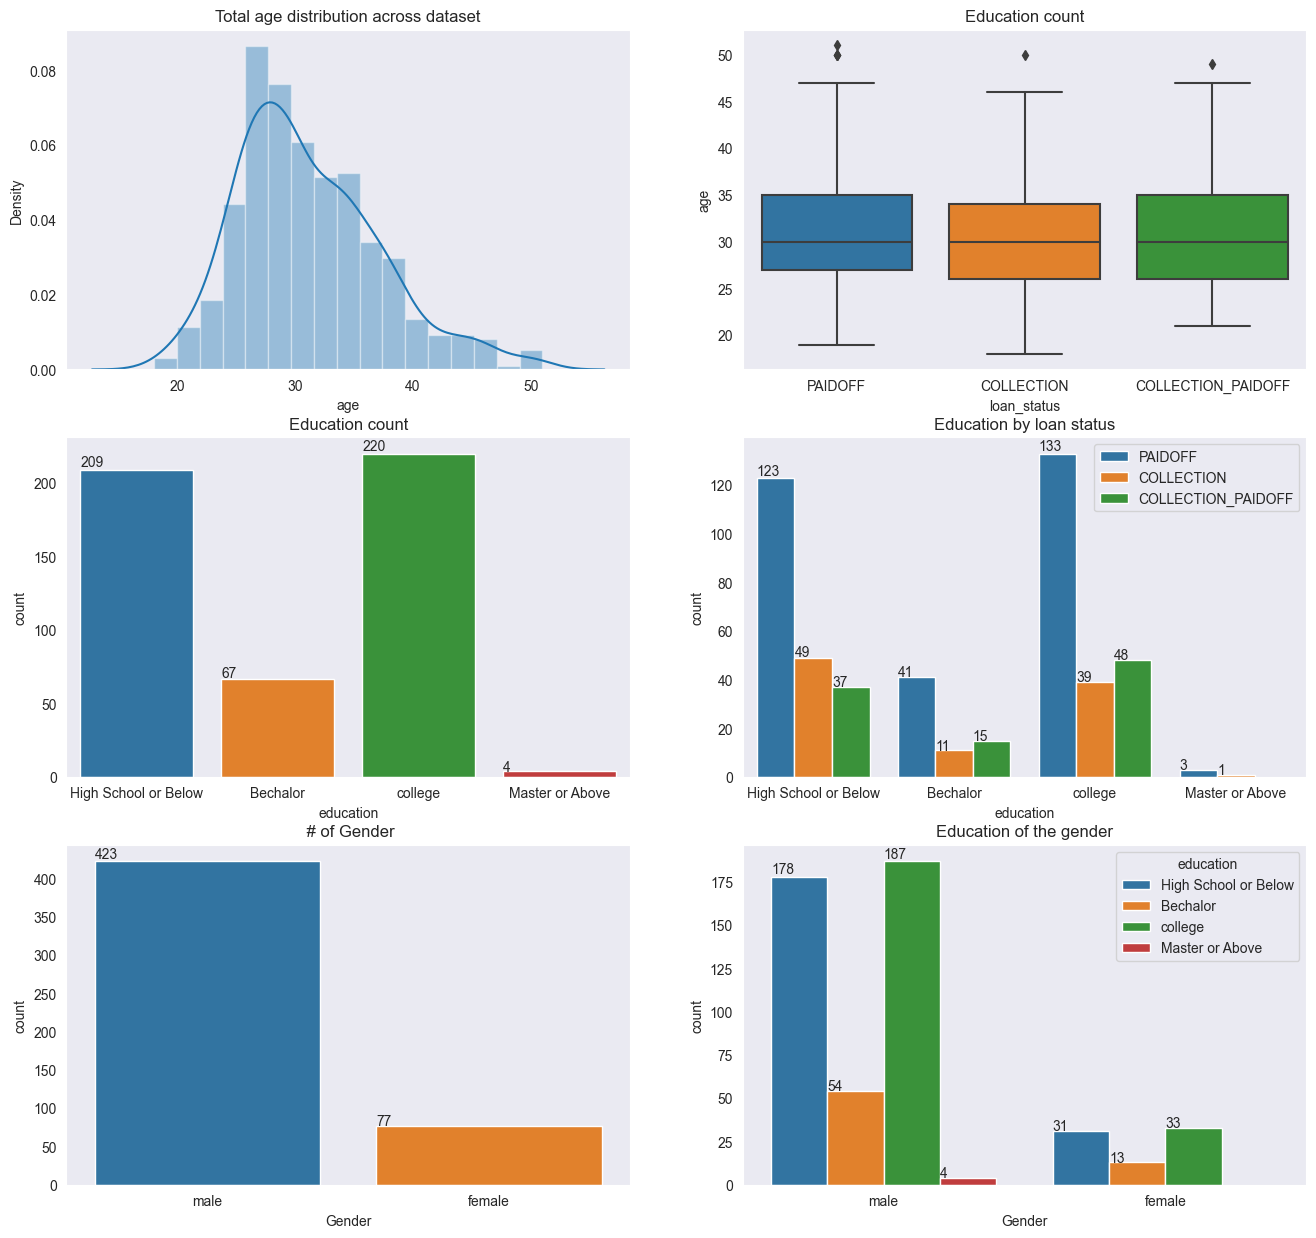

In [90]:
fig, axs = plt.subplots(3, 2, figsize=(16, 15))
sns.distplot(data.age, ax = axs[0][0])
axs[0][0].set_title("Total age distribution across dataset")
sns.boxplot(x = 'loan_status', y = 'age', data = data, ax = axs[0][1])
axs[0][1].set_title("Education count")
sns.countplot(x = 'education', data = data, ax = axs[1][0])
axs[1][0].set_title("Education count")
for t in axs[1][0].patches:
    if (np.isnan(float(t.get_height()))):
        axs[1][0].annotate('', (t.get_x(), 0))
    else:
        axs[1][0].annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

sns.countplot(x = 'education', data = data, hue = 'loan_status', ax = axs[1][1])
axs[1][1].set_title("Education by loan status")
for t in axs[1][1].patches:
    if (np.isnan(float(t.get_height()))):
        axs[1][1].annotate('', (t.get_x(), 0))
    else:
        axs[1][1].annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

axs[1][1].legend(loc = 'upper right')

sns.countplot(x = 'Gender', data = data, ax = axs[2][0])
axs[2][0].set_title(" # of Gender")
for t in axs[2][0].patches:
    if (np.isnan(float(t.get_height()))):
        axs[2][0].annotate('', (t.get_x(), 0))
    else:
        axs[2][0].annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

sns.countplot(x = 'Gender', data = data, hue = 'education', ax = axs[2][1])
axs[2][1].set_title("Education of the gender")
for t in axs[2][1].patches:
    if(np.isnan(float(t.get_height()))):
        axs[2][1].annotate('', (t.get_x(), 0))
    else:
        axs[2][1].annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

plt.show()

In [91]:
# quick view on education and gender affects loan_status
pd.crosstab(data.loan_status, data.Gender + '_' + data.education, margins = True)

col_0,female_Bechalor,female_High School or Below,female_college,male_Bechalor,male_High School or Below,male_Master or Above,male_college,All
loan_status,,,,,,,,
COLLECTION,0,7,3,11,42,1,36,100
COLLECTION_PAIDOFF,1,5,8,14,32,0,40,100
PAIDOFF,12,19,22,29,104,3,111,300
All,13,31,33,54,178,4,187,500


In [92]:
pd.crosstab(data.loan_status, data.Gender + '_' + data.education, margins = True, normalize = 'all')

col_0,female_Bechalor,female_High School or Below,female_college,male_Bechalor,male_High School or Below,male_Master or Above,male_college,All
loan_status,,,,,,,,
COLLECTION,0.000,0.014,0.006,0.022,0.084,0.002,0.072,0.2
COLLECTION_PAIDOFF,0.002,0.010,0.016,0.028,0.064,0.000,0.080,0.2
PAIDOFF,0.024,0.038,0.044,0.058,0.208,0.006,0.222,0.6
All,0.026,0.062,0.066,0.108,0.356,0.008,0.374,1.0


In [93]:
pd.crosstab(data.loan_status, data.Gender + '_' + data.education, margins = True, normalize = 'index')

col_0,female_Bechalor,female_High School or Below,female_college,male_Bechalor,male_High School or Below,male_Master or Above,male_college
loan_status,,,,,,,
COLLECTION,0.000,0.070000,0.030000,0.110000,0.420000,0.010,0.360
COLLECTION_PAIDOFF,0.010,0.050000,0.080000,0.140000,0.320000,0.000,0.400
PAIDOFF,0.040,0.063333,0.073333,0.096667,0.346667,0.010,0.370
All,0.026,0.062000,0.066000,0.108000,0.356000,0.008,0.374


In [94]:
pd.crosstab(data.loan_status, data.Gender + '_' + data.education, margins = True, normalize = 'columns')

col_0,female_Bechalor,female_High School or Below,female_college,male_Bechalor,male_High School or Below,male_Master or Above,male_college,All
loan_status,,,,,,,,
COLLECTION,0.000000,0.225806,0.090909,0.203704,0.235955,0.25,0.192513,0.2
COLLECTION_PAIDOFF,0.076923,0.161290,0.242424,0.259259,0.179775,0.00,0.213904,0.2
PAIDOFF,0.923077,0.612903,0.666667,0.537037,0.584270,0.75,0.593583,0.6


### Model, predict and solve

In [95]:
data.loc[(data.loan_status == 'PAIDOFF') & (data.day_to_pay > 30), 'loan_status'] = 'COLLECTION_PAIDOFF'

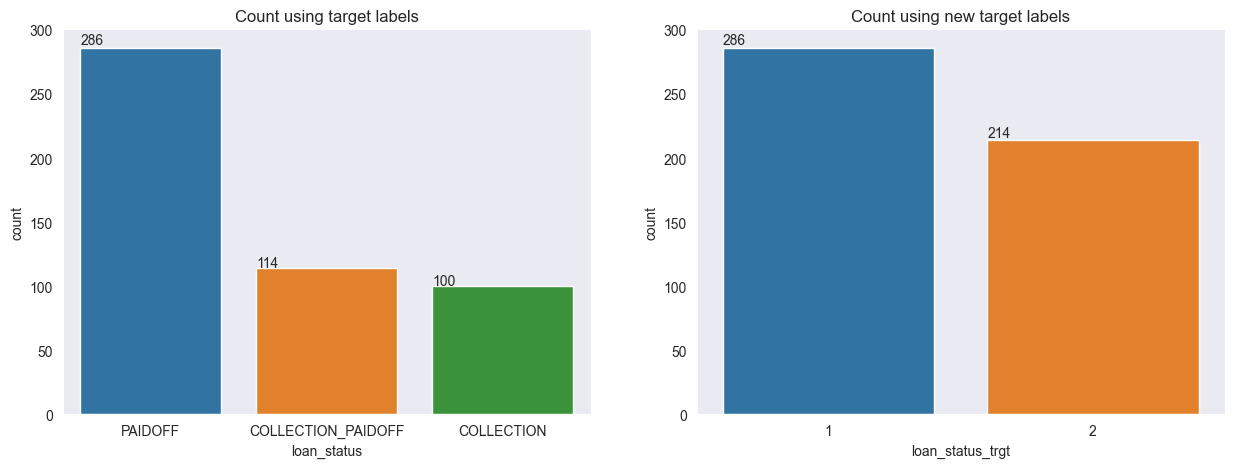

In [96]:
# assume those who are in COLLECTION or COLLECTION_PAIDOFF the same
status_map = {"PAIDOFF": 1, "COLLECTION": 2, "COLLECTION_PAIDOFF": 2}
data['loan_status_trgt'] = data['loan_status'].map(status_map)

fig, axs = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(x = 'loan_status', data = data, ax = axs[0])
axs[0].set_title("Count using target labels")
for t in axs[0].patches:
    if (np.isnan(float(t.get_height()))):
        axs[0].annotate('', (t.get_x(), 0))
    else:
        axs[0].annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

sns.countplot(x = 'loan_status_trgt', data = data, ax = axs[1])
axs[1].set_title("Count using new target labels")
for t in axs[1].patches:
    if (np.isnan(float(t.get_height()))):
        axs[1].annotate('', (t.get_x(), 0))
    else:
        axs[1].annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

plt.show()

In [98]:
# convert education and Gender to the dummy variables
dummies = pd.get_dummies(data['education']).rename(columns = lambda x: 'is_' + str(x))
data = pd.concat([data, dummies], axis =1)
data = data.drop(['education'], axis = 1)

dummies = pd.get_dummies(data['Gender']).rename(columns = lambda x: 'is_' + str(x))
data = pd.concat([data, dummies], axis = 1)
data = data.drop(['Gender'], axis = 1)

data = data.drop(['Loan_ID', 'loan_status', 'effective_date', 'due_date', 'paid_off_time', 'past_due_days', 'paid_off_date', 'day_to_pay'], axis = 1)

In [100]:
dummy_var = ['is_female', 'is_Master or Above']
data = data.drop(dummy_var, axis = 1)

print(data.head(2))

   Principal  terms  age  loan_status_trgt  is_Bechalor  \
0       1000     30   45                 1            0   
1       1000     30   50                 1            1   

   is_High School or Below  is_college  is_male  
0                        1           0        1  
1                        0           0        0  


In [101]:
X = data.drop(['loan_status_trgt'], axis = 1)
Y = data.loan_status_trgt

In [103]:
# create function to evaluate the score of each classification model
def eval_model_classifier(model, data, target, split_ratio):
    train_X, test_X, train_Y, test_Y = train_test_split(data, target, train_size = split_ratio, random_state = 0)
    model.fit(train_X, train_Y)
    return model.score(test_X, test_Y)

In [105]:
# randomforest classification
# initialise values
num_estimators_array = np.array([1, 5, 10, 50, 100, 200, 500])
num_smpl = 5
num_grid = len(num_estimators_array)
score_array_mu = np.zeros(num_grid) # keep mean
score_array_sigma = np.zeros(num_grid) # keep standard deviation
j = 0

print("{}: RandomForestClassification Starts!".format(now()))
for n_estimators in num_estimators_array:
    score_array = np.zeros(num_smpl) # initialize
    for i in range(0, num_smpl):
        rf_class = RandomForestClassifier(n_estimators = n_estimators, n_jobs = 1, criterion = 'gini')
        score_array[i] = eval_model_classifier(rf_class, X, Y, 0.8)
        print("{}: Try {} with n_estimators = {} and score = {}".format(now(), i, n_estimators, score_array[i]))
    score_array_mu[j], score_array_sigma[j] = np.mean(score_array), np.std(score_array)
    j += 1


print("{}: RandomForestClassification Done!".format(now()))

2022-08-30 18:54:37: RandomForestClassification Starts!
2022-08-30 18:54:37: Try 0 with n_estimators = 1 and score = 0.56
2022-08-30 18:54:37: Try 1 with n_estimators = 1 and score = 0.5
2022-08-30 18:54:37: Try 2 with n_estimators = 1 and score = 0.52
2022-08-30 18:54:37: Try 3 with n_estimators = 1 and score = 0.47
2022-08-30 18:54:37: Try 4 with n_estimators = 1 and score = 0.5
2022-08-30 18:54:37: Try 0 with n_estimators = 5 and score = 0.57
2022-08-30 18:54:37: Try 1 with n_estimators = 5 and score = 0.55
2022-08-30 18:54:37: Try 2 with n_estimators = 5 and score = 0.53
2022-08-30 18:54:37: Try 3 with n_estimators = 5 and score = 0.54
2022-08-30 18:54:37: Try 4 with n_estimators = 5 and score = 0.57
2022-08-30 18:54:37: Try 0 with n_estimators = 10 and score = 0.56
2022-08-30 18:54:37: Try 1 with n_estimators = 10 and score = 0.56
2022-08-30 18:54:37: Try 2 with n_estimators = 10 and score = 0.54
2022-08-30 18:54:37: Try 3 with n_estimators = 10 and score = 0.52
2022-08-30 18:54:3

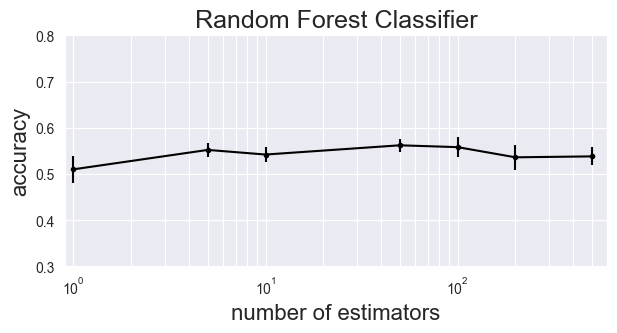

In [107]:
fig = plt.figure(figsize = (7, 3))
plt.errorbar(num_estimators_array, score_array_mu, yerr = score_array_sigma, fmt = 'k.-')
plt.xscale('log')
plt.xlabel("number of estimators", size = 16)
plt.ylabel("accuracy", size = 16)
plt.xlim(0.9, 600)
plt.ylim(0.3, 0.8)
plt.title("Random Forest Classifier", size = 18)
plt.grid(which = 'both')
plt.show();

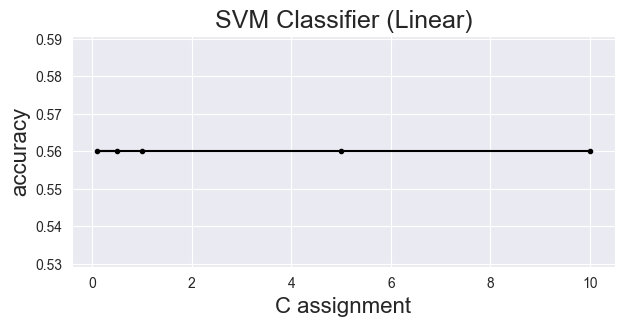

In [110]:
C_array = np.array([0.5, 0.1, 1, 5, 10])
score_array = np.zeros(len(C_array))
i = 0
for C_val in C_array:
    svc_class = svm.SVC(kernel = 'linear', random_state = 1, C = C_val)
    score_array[i] = eval_model_classifier(svc_class, X, Y, 0.8)
    i += 1

score_mu, score_sigma = np.mean(score_array), np.std(score_array)

fig = plt.figure(figsize = (7, 3))
plt.errorbar(C_array, score_array, yerr = score_sigma, fmt = 'k.-')
plt.xlabel("C assignment", size = 16)
plt.ylabel("accuracy", size = 16)
plt.title("SVM Classifier (Linear)", size = 18)
plt.grid(which = 'both')
plt.show()

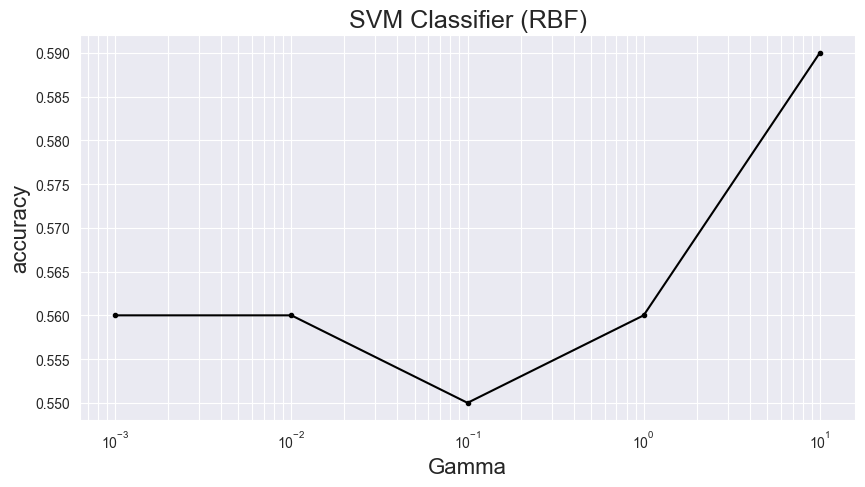

In [111]:
# Gamma: kernel cofficient, the higher, it will try to exact fit to the traning data, hence, can cause overfitting
gamma_array = np.array([0.001, 0.01, 0.1, 1, 10])
score_array = np.zeros(len(gamma_array))
score_mu = np.zeros(len(gamma_array))
score_sigma = np.zeros(len(gamma_array))
i = 0
for gamma_val in gamma_array:
    svc_class = svm.SVC(kernel = 'rbf', random_state = 1, gamma = gamma_val)
    score_array[i] = eval_model_classifier(svc_class, X, Y, 0.8)
    score_mu[i], score_sigma[i] = np.mean(score_array[i]), np.std(score_array[i])
    i += 1

fig = plt.figure(figsize = (10, 5))
plt.errorbar(gamma_array, score_mu, yerr = score_sigma, fmt = 'k.-')
plt.xscale('log')
plt.xlabel('Gamma', size = 16)
plt.ylabel('accuracy', size = 16)
plt.title("SVM Classifier (RBF)", size = 18)
plt.grid(which = 'both')
plt.show()

In [119]:
# change to np.array type
from mimetypes import init


new_X = np.array(X)
new_Y = np.array(Y)

# fix random seed for reproductibility
np.random.seed(1234)

model = Sequential()
model.add(Dense(64, input_dim = 7, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [120]:
model.fit(new_X, new_Y, epochs = 150, batch_size = 20)
scores = model.evaluate(new_X, new_Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Epoch 1/150
25/25 [==============================] - 0s 866us/step - loss: -71.3859 - accuracy: 0.5300
Epoch 2/150
25/25 [==============================] - 0s 940us/step - loss: -257.9105 - accuracy: 0.5720
Epoch 3/150
25/25 [==============================] - 0s 854us/step - loss: -623.2684 - accuracy: 0.5720
Epoch 4/150
25/25 [==============================] - 0s 1ms/step - loss: -1196.8848 - accuracy: 0.5720
Epoch 5/150
25/25 [==============================] - 0s 955us/step - loss: -1968.9005 - accuracy: 0.5720
Epoch 6/150
25/25 [==============================] - 0s 846us/step - loss: -3027.0085 - accuracy: 0.5720
Epoch 7/150
25/25 [==============================] - 0s 997us/step - loss: -4348.1064 - accuracy: 0.5720
Epoch 8/150
25/25 [==============================] - 0s 870us/step - loss: -6290.1299 - accuracy: 0.5720
Epoch 9/150
25/25 [==============================] - 0s 1ms/step - loss: -8234.5605 - accuracy: 0.5720
Epoch 10/150
25/25 [==============================] - 0s 844us/

###### * 아래 링크를 참고 했으며, 개인적인 공부를 위한 코드입니다.<br>참고) https://www.kaggle.com/code/netzone/loan-data-eda-simple-model